In [55]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import sklearn
print('sklearn version: ', sklearn.__version__)

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras
print('keras version: ', keras.__version__)
print('keras backend: ', keras.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import pickle

import random

from numpy.random import seed
from tensorflow import set_random_seed

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, auc,\
                            roc_curve, precision_recall_curve
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM, GRU, SimpleRNN, Dense, Dropout, Masking, TimeDistributed
from keras.optimizers import Adagrad, SGD, Adam
from keras.preprocessing.sequence import pad_sequences

python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
sklearn version:  0.21.2
keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [4]:
# load data
EXPERIMENT_NO = 1
file = open('processed_data/experiment%d_data' % EXPERIMENT_NO, 'rb')
X_train, y_train, X_test, y_test = pickle.load(file)
file.close()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [6]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [7]:
def scaler_transform(X_train, X_test):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train.drop('patient-id', axis=1)), 
                                       columns=X_train.columns[1:], index=X_train.index)                                   
    X_train_transformed['patient-id'] = X_train['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test.drop('patient-id', axis=1)),
                                       columns=X_test.columns[1:], index=X_test.index) 
    X_test_transformed['patient-id'] = X_test['patient-id']
    return X_train_transformed, X_test_transformed

In [8]:
# add previous outcome
X_train = add_previous_outcome(X_train, y_train)
X_test = add_previous_outcome(X_test, y_test)
X_train_transformed, X_test_transformed = scaler_transform(X_train, X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

In [10]:
"""
Generate list of lists, each element is a sequence
Input shape: (num_of_records, num_of_features)
Output shape: (num_of_records, various, num_of_features)
Example:
 [record1, record2, record3, ...] 
  --> [ [record1], [record1, record2], [record1, record2, record3], ...]
"""
def generate_nested_list(X, Y):
    x_list, y_list = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        x_array = df.drop('patient-id', axis=1).values
        y_array = Y[df.index].values
        x_cache = []
        for x, y in zip(x_array, y_array):
            x_cache.append(x)
            x_list.append(x_cache.copy())
            y_list.append([y])
    return x_list, y_list

In [11]:
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [12]:
# pad data to maximum length
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

In [13]:
maxlen = len(max(X_train_list, key=len))
X_train_pad = pad_data(X_train_list, maxlen)
X_test_pad = pad_data(X_test_list, maxlen)
print(X_train_pad.shape, X_test_pad.shape)

In [15]:
# transform y in numpy array
y_train_array, y_test_array = np.array(y_train_list), np.array(y_test_list)

In [16]:
# save padded data
if not os.path.exists('processed_data/experiment%d_padded_data' % EXPERIMENT_NO):
    file = open('processed_data/experiment%d_padded_data' % EXPERIMENT_NO, 'wb')
    pickle.dump((X_train_pad, y_train_array, X_test_pad, y_test_array), file)
    file.close()

In [16]:
def fit_model(model, epoch, X_train, y_train, generator=None, batch_size=None, 
              validation_split=None, validation_data=None, verbose=0):
    if(generator is not None):
        # input should be list
        if(validation_split is not None):
            train_size = int(len(X_train) * (1 - validation_split))
            X_train_ = X_train[:train_size]
            y_train_ = y_train[:train_size]
            X_valid = X_train[train_size:]
            y_valid = y_train[train_size:]
            history = model.fit_generator(generator(X_train_, y_train_), validation_data=generator(X_valid, y_valid), 
                                          steps_per_epoch=len(X_train_), validation_steps=len(X_valid),
                                          epochs=epoch, verbose=verbose)
        elif(validation_data is not None):
            history = model.fit_generator(generator(X_train, y_train), validation_data=validation_data, 
                                          steps_per_epoch=len(X_train), validation_steps=len(validation_data[0]),
                                          epochs=epoch, verbose=verbose)
        else:
            history = model.fit_generator(generator(X_train, y_train), steps_per_epoch=len(X_train), 
                                          epochs=epoch, verbose=verbose)
    else:
        # input should be numpy array
        history = model.fit(X_train, y_train, batch_size=batch_size, validation_split=validation_split, 
                            validation_data=validation_data, epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

In [17]:
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [18]:
def make_prediction(model, X, generator=None):
    if(generator is not None):
        y_predict = model.predict_generator(generator(X), steps=len(X))
    else:
        y_predict = model.predict(X)
    return np.concatenate(y_predict)

In [19]:
# calculate evaluation metrics
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)

def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

# draw roc plot
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def evaluation(model, X, y, generator=None):
    y_predict = make_prediction(model, X, generator=generator)
    f1, th = find_best_f1(y_predict, y)
    prec, recall, accu, spec = other_metrics(y_predict, y, th)
    return { 'auroc': auroc(y_predict, y), 'f1': f1, 'threshold': th, 
            'precision': prec, 'recall': recall, 'accuracy': accu, 'specificity': spec }

In [83]:
def build_model(unit_size, n_feature, input_dropout=0.5, recurrent_dropout=0.5, n_timestep=None):
    model = Sequential()
    model.add(Masking(input_shape=(n_timestep, n_feature)))
#     model.add(LSTM(unit_size, recurrent_dropout=recurrent_dropout, dropout=input_dropout)) # for single test
#     model.add(GRU(unit_size, recurrent_dropout=recurrent_dropout, dropout=input_dropout)) # for GRU test
    model.add(SimpleRNN(unit_size, recurrent_dropout=recurrent_dropout, dropout=input_dropout))
#     model.add(LSTM(unit_size, recurrent_dropout=0.5, return_sequences=True, dropout=0.5)) # for stacked test
#     model.add(LSTM(30, recurrent_dropout=0.5, dropout=0.5)) # for stacked test
    model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.03), metrics=['binary_accuracy']) # for optimizer test
    return model

### Repeat 1 time

Train on 5301 samples, validate on 2283 samples
Epoch 1/250
5301/5301 [==============================] - 50s 9ms/step - loss: 0.5148 - binary_accuracy: 0.7848 - val_loss: 0.4781 - val_binary_accuracy: 0.8103
Epoch 2/250
5301/5301 [==============================] - 2s 417us/step - loss: 0.4722 - binary_accuracy: 0.8180 - val_loss: 0.4705 - val_binary_accuracy: 0.8103
Epoch 3/250
5301/5301 [==============================] - 2s 427us/step - loss: 0.4635 - binary_accuracy: 0.8178 - val_loss: 0.4732 - val_binary_accuracy: 0.8103
Epoch 4/250
5301/5301 [==============================] - 2s 418us/step - loss: 0.4612 - binary_accuracy: 0.8183 - val_loss: 0.4698 - val_binary_accuracy: 0.8103
Epoch 5/250
5301/5301 [==============================] - 2s 423us/step - loss: 0.4581 - binary_accuracy: 0.8178 - val_loss: 0.4717 - val_binary_accuracy: 0.8103
Epoch 6/250
5301/5301 [==============================] - 2s 415us/step - loss: 0.4532 - binary_accuracy: 0.8191 - val_loss: 0.4635 - val_binary_accu

5301/5301 [==============================] - 2s 407us/step - loss: 0.4324 - binary_accuracy: 0.8200 - val_loss: 0.4412 - val_binary_accuracy: 0.8112
Epoch 102/250
5301/5301 [==============================] - 2s 407us/step - loss: 0.4307 - binary_accuracy: 0.8232 - val_loss: 0.4406 - val_binary_accuracy: 0.8108
Epoch 103/250
5301/5301 [==============================] - 2s 407us/step - loss: 0.4303 - binary_accuracy: 0.8206 - val_loss: 0.4405 - val_binary_accuracy: 0.8112
Epoch 104/250
5301/5301 [==============================] - 2s 406us/step - loss: 0.4336 - binary_accuracy: 0.8195 - val_loss: 0.4398 - val_binary_accuracy: 0.8103
Epoch 105/250
5301/5301 [==============================] - 2s 405us/step - loss: 0.4366 - binary_accuracy: 0.8214 - val_loss: 0.4395 - val_binary_accuracy: 0.8103
Epoch 106/250
5301/5301 [==============================] - 2s 407us/step - loss: 0.4328 - binary_accuracy: 0.8208 - val_loss: 0.4397 - val_binary_accuracy: 0.8112
Epoch 107/250
5301/5301 [===========

5301/5301 [==============================] - 2s 410us/step - loss: 0.4288 - binary_accuracy: 0.8214 - val_loss: 0.4368 - val_binary_accuracy: 0.8108
Epoch 202/250
5301/5301 [==============================] - 2s 407us/step - loss: 0.4308 - binary_accuracy: 0.8210 - val_loss: 0.4378 - val_binary_accuracy: 0.8112
Epoch 203/250
5301/5301 [==============================] - 2s 407us/step - loss: 0.4290 - binary_accuracy: 0.8212 - val_loss: 0.4382 - val_binary_accuracy: 0.8108
Epoch 204/250
5301/5301 [==============================] - 2s 407us/step - loss: 0.4300 - binary_accuracy: 0.8214 - val_loss: 0.4368 - val_binary_accuracy: 0.8112
Epoch 205/250
5301/5301 [==============================] - 2s 406us/step - loss: 0.4304 - binary_accuracy: 0.8240 - val_loss: 0.4403 - val_binary_accuracy: 0.8117
Epoch 206/250
5301/5301 [==============================] - 2s 403us/step - loss: 0.4296 - binary_accuracy: 0.8210 - val_loss: 0.4386 - val_binary_accuracy: 0.8117
Epoch 207/250
5301/5301 [===========

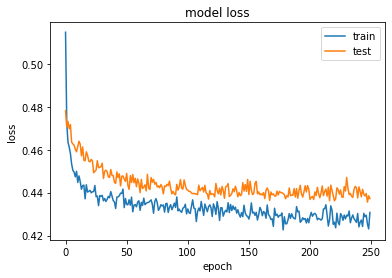

In [73]:
# fixed random seed, for reproducibility
seed(1)
set_random_seed(2)
n_feature = X_train_pad.shape[2]
model = build_model(22, n_feature, input_dropout=0.5, recurrent_dropout=0.5)
history = fit_model(model, 250, X_train_pad, y_train_array, batch_size=32, 
                    validation_data=(X_test_pad, y_test_array), verbose=1)

In [74]:
# test set performance
result = evaluation(model, X_test_pad, y_test_array)
for key in result:
    print(key, result[key])

auroc 0.7292853130266526
f1 0.4473257698541329
threshold 0.17559192
precision 0.3445692883895131
recall 0.6374133949191686
accuracy 0.7012702584318878
specificity 0.7162162162162162


In [67]:
# training set performance
result = evaluation(model, X_train_pad, y_train_array)
for key in result:
    print(key, ": ", result[key])

auroc :  0.7637260571501578
f1 :  0.4776394651913325
threshold :  0.22685423
precision :  0.428099173553719
recall :  0.5401459854014599
accuracy :  0.7862667421241275
specificity :  0.8406264394288346


### Repeat 5 times

Train on 5301 samples, validate on 2283 samples
Epoch 1/180
5301/5301 [==============================] - 84s 16ms/step - loss: 0.4710 - binary_accuracy: 0.8155 - val_loss: 0.4666 - val_binary_accuracy: 0.8103
Epoch 2/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4494 - binary_accuracy: 0.8195 - val_loss: 0.4589 - val_binary_accuracy: 0.8103
Epoch 3/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4442 - binary_accuracy: 0.8189 - val_loss: 0.4610 - val_binary_accuracy: 0.8103
Epoch 4/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4386 - binary_accuracy: 0.8189 - val_loss: 0.4590 - val_binary_accuracy: 0.8103
Epoch 5/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4349 - binary_accuracy: 0.8202 - val_loss: 0.4538 - val_binary_accuracy: 0.8103
Epoch 6/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4324 - binary_accuracy: 0.8193 - val_loss: 0.4531 - val_binary_accuracy: 0.8

Epoch 52/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4182 - binary_accuracy: 0.8255 - val_loss: 0.4378 - val_binary_accuracy: 0.8134
Epoch 53/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4155 - binary_accuracy: 0.8223 - val_loss: 0.4380 - val_binary_accuracy: 0.8134
Epoch 54/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4190 - binary_accuracy: 0.8255 - val_loss: 0.4376 - val_binary_accuracy: 0.8143
Epoch 55/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4148 - binary_accuracy: 0.8244 - val_loss: 0.4382 - val_binary_accuracy: 0.8134
Epoch 56/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4173 - binary_accuracy: 0.8251 - val_loss: 0.4379 - val_binary_accuracy: 0.8138
Epoch 57/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4154 - binary_accuracy: 0.8240 - val_loss: 0.4373 - val_binary_accuracy: 0.8138
Epoch 58/180
5301/5301 [================

Epoch 154/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4083 - binary_accuracy: 0.8295 - val_loss: 0.4365 - val_binary_accuracy: 0.8121
Epoch 155/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4117 - binary_accuracy: 0.8266 - val_loss: 0.4364 - val_binary_accuracy: 0.8121
Epoch 156/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4119 - binary_accuracy: 0.8231 - val_loss: 0.4364 - val_binary_accuracy: 0.8130
Epoch 157/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4105 - binary_accuracy: 0.8261 - val_loss: 0.4366 - val_binary_accuracy: 0.8125
Epoch 158/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4114 - binary_accuracy: 0.8306 - val_loss: 0.4368 - val_binary_accuracy: 0.8121
Epoch 159/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4083 - binary_accuracy: 0.8293 - val_loss: 0.4366 - val_binary_accuracy: 0.8125
Epoch 160/180
5301/5301 [=========

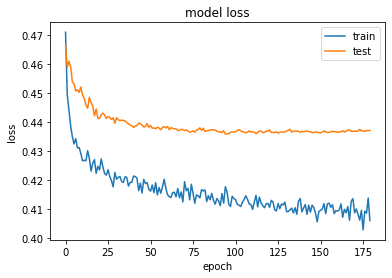

Train on 5301 samples, validate on 2283 samples
Epoch 1/180
5301/5301 [==============================] - 85s 16ms/step - loss: 0.4727 - binary_accuracy: 0.8181 - val_loss: 0.4725 - val_binary_accuracy: 0.8103
Epoch 2/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4496 - binary_accuracy: 0.8191 - val_loss: 0.4652 - val_binary_accuracy: 0.8103
Epoch 3/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4411 - binary_accuracy: 0.8197 - val_loss: 0.4567 - val_binary_accuracy: 0.8103
Epoch 4/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4376 - binary_accuracy: 0.8210 - val_loss: 0.4582 - val_binary_accuracy: 0.8103
Epoch 5/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4363 - binary_accuracy: 0.8204 - val_loss: 0.4550 - val_binary_accuracy: 0.8103
Epoch 6/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4351 - binary_accuracy: 0.8208 - val_loss: 0.4544 - val_binary_accuracy: 0.8

Epoch 52/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4138 - binary_accuracy: 0.8272 - val_loss: 0.4410 - val_binary_accuracy: 0.8134
Epoch 53/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4161 - binary_accuracy: 0.8259 - val_loss: 0.4401 - val_binary_accuracy: 0.8130
Epoch 54/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4196 - binary_accuracy: 0.8249 - val_loss: 0.4391 - val_binary_accuracy: 0.8134
Epoch 55/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4155 - binary_accuracy: 0.8234 - val_loss: 0.4396 - val_binary_accuracy: 0.8130
Epoch 56/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4160 - binary_accuracy: 0.8268 - val_loss: 0.4406 - val_binary_accuracy: 0.8138
Epoch 57/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4162 - binary_accuracy: 0.8264 - val_loss: 0.4410 - val_binary_accuracy: 0.8134
Epoch 58/180
5301/5301 [================

Epoch 154/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4075 - binary_accuracy: 0.8287 - val_loss: 0.4370 - val_binary_accuracy: 0.8117
Epoch 155/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4128 - binary_accuracy: 0.8268 - val_loss: 0.4370 - val_binary_accuracy: 0.8117
Epoch 156/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4127 - binary_accuracy: 0.8298 - val_loss: 0.4368 - val_binary_accuracy: 0.8121
Epoch 157/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4113 - binary_accuracy: 0.8251 - val_loss: 0.4362 - val_binary_accuracy: 0.8121
Epoch 158/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4120 - binary_accuracy: 0.8236 - val_loss: 0.4370 - val_binary_accuracy: 0.8125
Epoch 159/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4096 - binary_accuracy: 0.8266 - val_loss: 0.4368 - val_binary_accuracy: 0.8121
Epoch 160/180
5301/5301 [=========

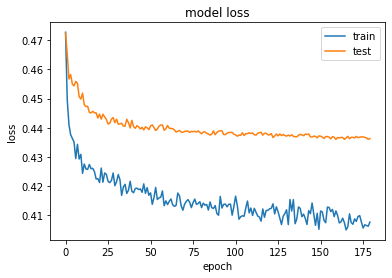

Train on 5301 samples, validate on 2283 samples
Epoch 1/180
5301/5301 [==============================] - 85s 16ms/step - loss: 0.4789 - binary_accuracy: 0.8146 - val_loss: 0.4643 - val_binary_accuracy: 0.8103
Epoch 2/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4461 - binary_accuracy: 0.8197 - val_loss: 0.4568 - val_binary_accuracy: 0.8103
Epoch 3/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4380 - binary_accuracy: 0.8204 - val_loss: 0.4543 - val_binary_accuracy: 0.8103
Epoch 4/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4386 - binary_accuracy: 0.8195 - val_loss: 0.4524 - val_binary_accuracy: 0.8103
Epoch 5/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4311 - binary_accuracy: 0.8206 - val_loss: 0.4505 - val_binary_accuracy: 0.8099
Epoch 6/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4284 - binary_accuracy: 0.8202 - val_loss: 0.4519 - val_binary_accuracy: 0.8

Epoch 52/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4183 - binary_accuracy: 0.8246 - val_loss: 0.4406 - val_binary_accuracy: 0.8130
Epoch 53/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4180 - binary_accuracy: 0.8236 - val_loss: 0.4408 - val_binary_accuracy: 0.8134
Epoch 54/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4156 - binary_accuracy: 0.8261 - val_loss: 0.4405 - val_binary_accuracy: 0.8130
Epoch 55/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4177 - binary_accuracy: 0.8251 - val_loss: 0.4415 - val_binary_accuracy: 0.8130
Epoch 56/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4177 - binary_accuracy: 0.8263 - val_loss: 0.4413 - val_binary_accuracy: 0.8130
Epoch 57/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4164 - binary_accuracy: 0.8268 - val_loss: 0.4405 - val_binary_accuracy: 0.8125
Epoch 58/180
5301/5301 [================

Epoch 154/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4058 - binary_accuracy: 0.8321 - val_loss: 0.4386 - val_binary_accuracy: 0.8134
Epoch 155/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4110 - binary_accuracy: 0.8287 - val_loss: 0.4389 - val_binary_accuracy: 0.8130
Epoch 156/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4089 - binary_accuracy: 0.8272 - val_loss: 0.4389 - val_binary_accuracy: 0.8134
Epoch 157/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4114 - binary_accuracy: 0.8248 - val_loss: 0.4389 - val_binary_accuracy: 0.8130
Epoch 158/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4092 - binary_accuracy: 0.8293 - val_loss: 0.4390 - val_binary_accuracy: 0.8130
Epoch 159/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4084 - binary_accuracy: 0.8276 - val_loss: 0.4388 - val_binary_accuracy: 0.8125
Epoch 160/180
5301/5301 [=========

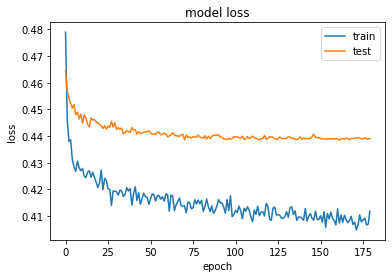

Train on 5301 samples, validate on 2283 samples
Epoch 1/180
5301/5301 [==============================] - 91s 17ms/step - loss: 0.4764 - binary_accuracy: 0.8166 - val_loss: 0.4744 - val_binary_accuracy: 0.8103
Epoch 2/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4453 - binary_accuracy: 0.8197 - val_loss: 0.4642 - val_binary_accuracy: 0.8103
Epoch 3/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4422 - binary_accuracy: 0.8183 - val_loss: 0.4631 - val_binary_accuracy: 0.8103
Epoch 4/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4383 - binary_accuracy: 0.8204 - val_loss: 0.4590 - val_binary_accuracy: 0.8103
Epoch 5/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4348 - binary_accuracy: 0.8204 - val_loss: 0.4558 - val_binary_accuracy: 0.8099
Epoch 6/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4345 - binary_accuracy: 0.8183 - val_loss: 0.4562 - val_binary_accuracy: 0.8

Epoch 52/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4178 - binary_accuracy: 0.8281 - val_loss: 0.4406 - val_binary_accuracy: 0.8130
Epoch 53/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4140 - binary_accuracy: 0.8259 - val_loss: 0.4415 - val_binary_accuracy: 0.8134
Epoch 54/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4159 - binary_accuracy: 0.8221 - val_loss: 0.4403 - val_binary_accuracy: 0.8125
Epoch 55/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4150 - binary_accuracy: 0.8274 - val_loss: 0.4403 - val_binary_accuracy: 0.8130
Epoch 56/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4186 - binary_accuracy: 0.8268 - val_loss: 0.4408 - val_binary_accuracy: 0.8134
Epoch 57/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4172 - binary_accuracy: 0.8253 - val_loss: 0.4405 - val_binary_accuracy: 0.8130
Epoch 58/180
5301/5301 [================

Epoch 154/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4119 - binary_accuracy: 0.8249 - val_loss: 0.4388 - val_binary_accuracy: 0.8125
Epoch 155/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4061 - binary_accuracy: 0.8274 - val_loss: 0.4386 - val_binary_accuracy: 0.8125
Epoch 156/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4084 - binary_accuracy: 0.8285 - val_loss: 0.4388 - val_binary_accuracy: 0.8125
Epoch 157/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4106 - binary_accuracy: 0.8257 - val_loss: 0.4388 - val_binary_accuracy: 0.8125
Epoch 158/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4096 - binary_accuracy: 0.8278 - val_loss: 0.4389 - val_binary_accuracy: 0.8125
Epoch 159/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4111 - binary_accuracy: 0.8281 - val_loss: 0.4384 - val_binary_accuracy: 0.8134
Epoch 160/180
5301/5301 [=========

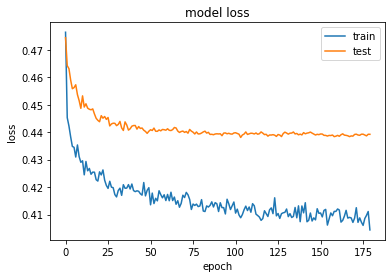

Train on 5301 samples, validate on 2283 samples
Epoch 1/180
5301/5301 [==============================] - 88s 17ms/step - loss: 0.4775 - binary_accuracy: 0.8157 - val_loss: 0.4695 - val_binary_accuracy: 0.8103
Epoch 2/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4491 - binary_accuracy: 0.8193 - val_loss: 0.4620 - val_binary_accuracy: 0.8103
Epoch 3/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4388 - binary_accuracy: 0.8206 - val_loss: 0.4608 - val_binary_accuracy: 0.8103
Epoch 4/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4389 - binary_accuracy: 0.8195 - val_loss: 0.4589 - val_binary_accuracy: 0.8103
Epoch 5/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4340 - binary_accuracy: 0.8204 - val_loss: 0.4538 - val_binary_accuracy: 0.8103
Epoch 6/180
5301/5301 [==============================] - 7s 1ms/step - loss: 0.4355 - binary_accuracy: 0.8189 - val_loss: 0.4514 - val_binary_accuracy: 0.8

Epoch 52/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4194 - binary_accuracy: 0.8268 - val_loss: 0.4416 - val_binary_accuracy: 0.8108
Epoch 53/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4185 - binary_accuracy: 0.8246 - val_loss: 0.4423 - val_binary_accuracy: 0.8103
Epoch 54/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4176 - binary_accuracy: 0.8242 - val_loss: 0.4422 - val_binary_accuracy: 0.8103
Epoch 55/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4161 - binary_accuracy: 0.8298 - val_loss: 0.4411 - val_binary_accuracy: 0.8112
Epoch 56/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4156 - binary_accuracy: 0.8255 - val_loss: 0.4415 - val_binary_accuracy: 0.8108
Epoch 57/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4158 - binary_accuracy: 0.8266 - val_loss: 0.4410 - val_binary_accuracy: 0.8125
Epoch 58/180
5301/5301 [================

Epoch 154/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4083 - binary_accuracy: 0.8293 - val_loss: 0.4402 - val_binary_accuracy: 0.8117
Epoch 155/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4100 - binary_accuracy: 0.8285 - val_loss: 0.4400 - val_binary_accuracy: 0.8117
Epoch 156/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4102 - binary_accuracy: 0.8295 - val_loss: 0.4402 - val_binary_accuracy: 0.8121
Epoch 157/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4071 - binary_accuracy: 0.8332 - val_loss: 0.4400 - val_binary_accuracy: 0.8117
Epoch 158/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4114 - binary_accuracy: 0.8253 - val_loss: 0.4403 - val_binary_accuracy: 0.8117
Epoch 159/180
5301/5301 [==============================] - 6s 1ms/step - loss: 0.4107 - binary_accuracy: 0.8246 - val_loss: 0.4402 - val_binary_accuracy: 0.8117
Epoch 160/180
5301/5301 [=========

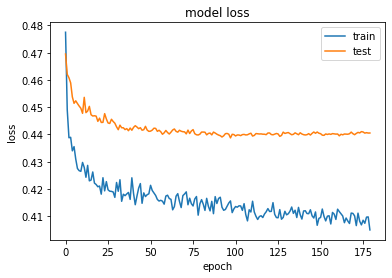

In [213]:
# see average performance with different initial state
seed(1)
set_random_seed(2)
n_feature = X_train_pad.shape[2]
models, histories, results = [], [], []
for i in range(5):
    model = build_model(22, n_feature, input_dropout=0.5, recurrent_dropout=0.5)
    history = fit_model(model, 180, X_train_pad, y_train_array, batch_size=32, 
                        validation_data=(X_test_pad, y_test_array), verbose=1)
    result = evaluation(model, X_test_pad, y_test_array)
    models.append(model)
    histories.append(history)
    results.append(result)

In [245]:
aurocs = [result['auroc'] for result in results]
print(aurocs)
print('average auroc: %f\tstd: %f' % (np.mean(aurocs), np.std(aurocs)))

[0.7271231508644903, 0.7289270332688347, 0.7235565819861433, 0.7245945945945946, 0.7234092753261343]
average auroc: 0.725522	std: 0.002161


In [217]:
for result in results:
    for key in result:
        print(key, result[key])
    print('\n')

auroc 0.7271231508644903
f1 0.44644644644644643
threshold 0.20309684
precision 0.39399293286219084
recall 0.5150115473441108
accuracy 0.7577748576434516
specificity 0.8145945945945946


auroc 0.7289270332688347
f1 0.4527595884003742
threshold 0.18956622
precision 0.3805031446540881
recall 0.558891454965358
accuracy 0.7437582128777924
specificity 0.787027027027027


auroc 0.7235565819861433
f1 0.4465608465608466
threshold 0.21893999
precision 0.412109375
recall 0.48729792147806006
accuracy 0.7709154621112572
specificity 0.8372972972972973


auroc 0.7245945945945946
f1 0.4407766990291262
threshold 0.19455898
precision 0.38023450586264657
recall 0.5242494226327945
accuracy 0.7477003942181341
specificity 0.8


auroc 0.7234092753261343
f1 0.44600526777875327
threshold 0.17138392
precision 0.3597733711048159
recall 0.5866050808314087
accuracy 0.7236092860271572
specificity 0.7556756756756757




In [237]:
# save results
result_file = open('results/experiment%d_result' % EXPERIMENT_NO, 'wb')
pickle.dump(results, result_file)
result_file.close()

In [238]:
# save models
for i, model in enumerate(models):
    model.save('trained_models/experiment%d_model%d.h5' % (EXPERIMENT_NO, i))
    
# Use following command to load
# keras.models.load_model('path_to_my_model.h5')

In [22]:
# input should be scaled dataframe
def kfold_validation(X, y, groupby, unit_size, epoch, input_dropout=0.5, recurrent_dropout=0.5, batch_size=32, k=5, verbose=1):
    auroc_list, history_list = [], []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        # generate list of lists
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        y_train, y_valid = np.array(y_train), np.array(y_valid)
        # padding
        maxlen = len(max(X_train, key=len))
        X_train_pad = pad_data(X_train, maxlen)
        X_valid_pad = pad_data(X_valid, maxlen)
        # training
        seed(1)
        set_random_seed(2)
        n_feature = X_train_pad.shape[2]
        model = build_model(unit_size, n_feature, input_dropout=input_dropout, recurrent_dropout=recurrent_dropout)
        history = fit_model(model, epoch, X_train_pad, y_train, batch_size=batch_size, 
                            validation_data=(X_valid_pad, y_valid), verbose=verbose)
        history_list.append(history)
        # evaluation
        y_predict = make_prediction(model, X_valid_pad)
        auroc_list.append(auroc(y_predict, y_valid))
    return auroc_list, history_list

Train on 4240 samples, validate on 1061 samples
Epoch 1/200
4240/4240 [==============================] - 64s 15ms/step - loss: 0.5014 - binary_accuracy: 0.7925 - val_loss: 0.4701 - val_binary_accuracy: 0.8228
Epoch 2/200
4240/4240 [==============================] - 2s 391us/step - loss: 0.4670 - binary_accuracy: 0.8118 - val_loss: 0.4608 - val_binary_accuracy: 0.8219
Epoch 3/200
4240/4240 [==============================] - 2s 382us/step - loss: 0.4654 - binary_accuracy: 0.8146 - val_loss: 0.4554 - val_binary_accuracy: 0.8219
Epoch 4/200
4240/4240 [==============================] - 2s 378us/step - loss: 0.4591 - binary_accuracy: 0.8177 - val_loss: 0.4475 - val_binary_accuracy: 0.8228
Epoch 5/200
4240/4240 [==============================] - 2s 381us/step - loss: 0.4559 - binary_accuracy: 0.8179 - val_loss: 0.4434 - val_binary_accuracy: 0.8228
Epoch 6/200
4240/4240 [==============================] - 2s 380us/step - loss: 0.4542 - binary_accuracy: 0.8144 - val_loss: 0.4355 - val_binary_acc

4240/4240 [==============================] - 2s 372us/step - loss: 0.4311 - binary_accuracy: 0.8210 - val_loss: 0.4266 - val_binary_accuracy: 0.8266
Epoch 102/200
4240/4240 [==============================] - 2s 377us/step - loss: 0.4316 - binary_accuracy: 0.8182 - val_loss: 0.4270 - val_binary_accuracy: 0.8266
Epoch 103/200
4240/4240 [==============================] - 2s 373us/step - loss: 0.4377 - binary_accuracy: 0.8193 - val_loss: 0.4266 - val_binary_accuracy: 0.8285
Epoch 104/200
4240/4240 [==============================] - 2s 378us/step - loss: 0.4341 - binary_accuracy: 0.8198 - val_loss: 0.4272 - val_binary_accuracy: 0.8275
Epoch 105/200
4240/4240 [==============================] - 2s 379us/step - loss: 0.4288 - binary_accuracy: 0.8233 - val_loss: 0.4267 - val_binary_accuracy: 0.8275
Epoch 106/200
4240/4240 [==============================] - 2s 381us/step - loss: 0.4330 - binary_accuracy: 0.8205 - val_loss: 0.4265 - val_binary_accuracy: 0.8294
Epoch 107/200
4240/4240 [===========

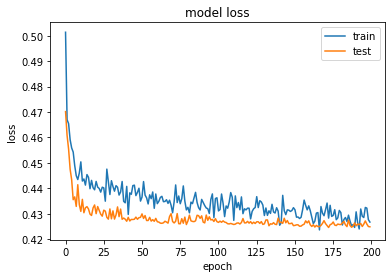

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 60s 14ms/step - loss: 0.5045 - binary_accuracy: 0.7934 - val_loss: 0.4826 - val_binary_accuracy: 0.8123
Epoch 2/200
4241/4241 [==============================] - 2s 463us/step - loss: 0.4699 - binary_accuracy: 0.8121 - val_loss: 0.4695 - val_binary_accuracy: 0.8123
Epoch 3/200
4241/4241 [==============================] - 2s 463us/step - loss: 0.4665 - binary_accuracy: 0.8177 - val_loss: 0.4539 - val_binary_accuracy: 0.8123
Epoch 4/200
4241/4241 [==============================] - 2s 458us/step - loss: 0.4638 - binary_accuracy: 0.8199 - val_loss: 0.4528 - val_binary_accuracy: 0.8123
Epoch 5/200
4241/4241 [==============================] - 2s 452us/step - loss: 0.4554 - binary_accuracy: 0.8206 - val_loss: 0.4453 - val_binary_accuracy: 0.8132
Epoch 6/200
4241/4241 [==============================] - 2s 451us/step - loss: 0.4511 - binary_accuracy: 0.8199 - val_loss: 0.4465 - val_binary_acc

4241/4241 [==============================] - 2s 435us/step - loss: 0.4296 - binary_accuracy: 0.8227 - val_loss: 0.4329 - val_binary_accuracy: 0.8142
Epoch 102/200
4241/4241 [==============================] - 2s 448us/step - loss: 0.4296 - binary_accuracy: 0.8227 - val_loss: 0.4292 - val_binary_accuracy: 0.8113
Epoch 103/200
4241/4241 [==============================] - 2s 446us/step - loss: 0.4339 - binary_accuracy: 0.8234 - val_loss: 0.4305 - val_binary_accuracy: 0.8132
Epoch 104/200
4241/4241 [==============================] - 2s 451us/step - loss: 0.4267 - binary_accuracy: 0.8241 - val_loss: 0.4297 - val_binary_accuracy: 0.8132
Epoch 105/200
4241/4241 [==============================] - 2s 447us/step - loss: 0.4310 - binary_accuracy: 0.8241 - val_loss: 0.4301 - val_binary_accuracy: 0.8142
Epoch 106/200
4241/4241 [==============================] - 2s 447us/step - loss: 0.4288 - binary_accuracy: 0.8265 - val_loss: 0.4296 - val_binary_accuracy: 0.8132
Epoch 107/200
4241/4241 [===========

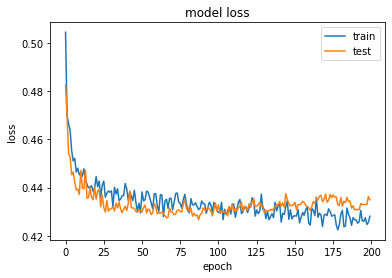

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 58s 14ms/step - loss: 0.5014 - binary_accuracy: 0.7972 - val_loss: 0.5033 - val_binary_accuracy: 0.8075
Epoch 2/200
4241/4241 [==============================] - 2s 460us/step - loss: 0.4660 - binary_accuracy: 0.8168 - val_loss: 0.4890 - val_binary_accuracy: 0.8075
Epoch 3/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4597 - binary_accuracy: 0.8196 - val_loss: 0.4704 - val_binary_accuracy: 0.8075
Epoch 4/200
4241/4241 [==============================] - 2s 445us/step - loss: 0.4546 - binary_accuracy: 0.8196 - val_loss: 0.4680 - val_binary_accuracy: 0.8085
Epoch 5/200
4241/4241 [==============================] - 2s 443us/step - loss: 0.4532 - binary_accuracy: 0.8208 - val_loss: 0.4629 - val_binary_accuracy: 0.8085
Epoch 6/200
4241/4241 [==============================] - 2s 449us/step - loss: 0.4405 - binary_accuracy: 0.8227 - val_loss: 0.4564 - val_binary_acc

4241/4241 [==============================] - 2s 441us/step - loss: 0.4313 - binary_accuracy: 0.8241 - val_loss: 0.4427 - val_binary_accuracy: 0.8094
Epoch 102/200
4241/4241 [==============================] - 2s 445us/step - loss: 0.4310 - binary_accuracy: 0.8243 - val_loss: 0.4426 - val_binary_accuracy: 0.8094
Epoch 103/200
4241/4241 [==============================] - 2s 448us/step - loss: 0.4325 - binary_accuracy: 0.8246 - val_loss: 0.4404 - val_binary_accuracy: 0.8123
Epoch 104/200
4241/4241 [==============================] - 2s 441us/step - loss: 0.4291 - binary_accuracy: 0.8262 - val_loss: 0.4418 - val_binary_accuracy: 0.8085
Epoch 105/200
4241/4241 [==============================] - 2s 446us/step - loss: 0.4306 - binary_accuracy: 0.8243 - val_loss: 0.4426 - val_binary_accuracy: 0.8085
Epoch 106/200
4241/4241 [==============================] - 2s 446us/step - loss: 0.4262 - binary_accuracy: 0.8217 - val_loss: 0.4404 - val_binary_accuracy: 0.8113
Epoch 107/200
4241/4241 [===========

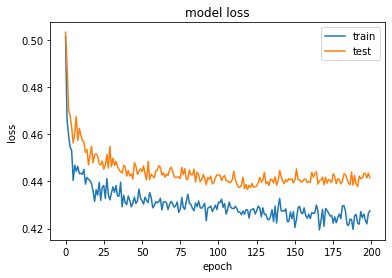

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 61s 14ms/step - loss: 0.5055 - binary_accuracy: 0.7876 - val_loss: 0.4673 - val_binary_accuracy: 0.8236
Epoch 2/200
4241/4241 [==============================] - 2s 460us/step - loss: 0.4701 - binary_accuracy: 0.8144 - val_loss: 0.4478 - val_binary_accuracy: 0.8236
Epoch 3/200
4241/4241 [==============================] - 2s 451us/step - loss: 0.4646 - binary_accuracy: 0.8147 - val_loss: 0.4537 - val_binary_accuracy: 0.8236
Epoch 4/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4529 - binary_accuracy: 0.8161 - val_loss: 0.4534 - val_binary_accuracy: 0.8236
Epoch 5/200
4241/4241 [==============================] - 2s 453us/step - loss: 0.4538 - binary_accuracy: 0.8154 - val_loss: 0.4543 - val_binary_accuracy: 0.8236
Epoch 6/200
4241/4241 [==============================] - 2s 457us/step - loss: 0.4559 - binary_accuracy: 0.8168 - val_loss: 0.4377 - val_binary_acc

4241/4241 [==============================] - 2s 447us/step - loss: 0.4342 - binary_accuracy: 0.8180 - val_loss: 0.4220 - val_binary_accuracy: 0.8236
Epoch 102/200
4241/4241 [==============================] - 2s 440us/step - loss: 0.4296 - binary_accuracy: 0.8199 - val_loss: 0.4189 - val_binary_accuracy: 0.8264
Epoch 103/200
4241/4241 [==============================] - 2s 432us/step - loss: 0.4360 - binary_accuracy: 0.8224 - val_loss: 0.4193 - val_binary_accuracy: 0.8226
Epoch 104/200
4241/4241 [==============================] - 2s 434us/step - loss: 0.4379 - binary_accuracy: 0.8187 - val_loss: 0.4225 - val_binary_accuracy: 0.8226
Epoch 105/200
4241/4241 [==============================] - 2s 453us/step - loss: 0.4331 - binary_accuracy: 0.8215 - val_loss: 0.4208 - val_binary_accuracy: 0.8236
Epoch 106/200
4241/4241 [==============================] - 2s 451us/step - loss: 0.4365 - binary_accuracy: 0.8175 - val_loss: 0.4226 - val_binary_accuracy: 0.8226
Epoch 107/200
4241/4241 [===========

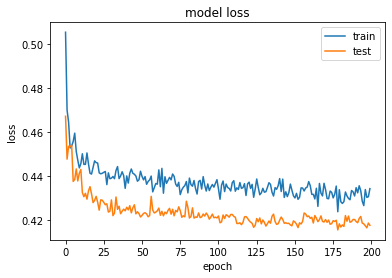

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 61s 14ms/step - loss: 0.5038 - binary_accuracy: 0.7927 - val_loss: 0.4456 - val_binary_accuracy: 0.8292
Epoch 2/200
4241/4241 [==============================] - 2s 464us/step - loss: 0.4794 - binary_accuracy: 0.8114 - val_loss: 0.4343 - val_binary_accuracy: 0.8302
Epoch 3/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4629 - binary_accuracy: 0.8130 - val_loss: 0.4249 - val_binary_accuracy: 0.8302
Epoch 4/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4589 - binary_accuracy: 0.8151 - val_loss: 0.4234 - val_binary_accuracy: 0.8302
Epoch 5/200
4241/4241 [==============================] - 2s 463us/step - loss: 0.4634 - binary_accuracy: 0.8116 - val_loss: 0.4247 - val_binary_accuracy: 0.8302
Epoch 6/200
4241/4241 [==============================] - 2s 455us/step - loss: 0.4540 - binary_accuracy: 0.8163 - val_loss: 0.4231 - val_binary_acc

4241/4241 [==============================] - 2s 439us/step - loss: 0.4347 - binary_accuracy: 0.8196 - val_loss: 0.4124 - val_binary_accuracy: 0.8292
Epoch 102/200
4241/4241 [==============================] - 2s 437us/step - loss: 0.4406 - binary_accuracy: 0.8151 - val_loss: 0.4122 - val_binary_accuracy: 0.8283
Epoch 103/200
4241/4241 [==============================] - 2s 430us/step - loss: 0.4336 - binary_accuracy: 0.8191 - val_loss: 0.4118 - val_binary_accuracy: 0.8302
Epoch 104/200
4241/4241 [==============================] - 2s 431us/step - loss: 0.4295 - binary_accuracy: 0.8208 - val_loss: 0.4116 - val_binary_accuracy: 0.8340
Epoch 105/200
4241/4241 [==============================] - 2s 426us/step - loss: 0.4354 - binary_accuracy: 0.8196 - val_loss: 0.4130 - val_binary_accuracy: 0.8302
Epoch 106/200
4241/4241 [==============================] - 2s 431us/step - loss: 0.4323 - binary_accuracy: 0.8241 - val_loss: 0.4145 - val_binary_accuracy: 0.8330
Epoch 107/200
4241/4241 [===========

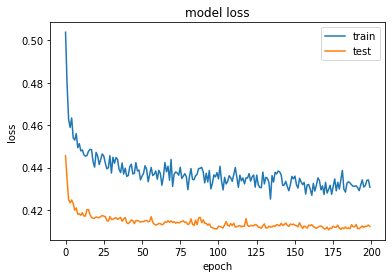

unit: 34	epoch: 200	auroc_mean: 0.723622	auroc_std: 0.008857
Train on 4240 samples, validate on 1061 samples
Epoch 1/200
4240/4240 [==============================] - 60s 14ms/step - loss: 0.5106 - binary_accuracy: 0.7960 - val_loss: 0.4543 - val_binary_accuracy: 0.8228
Epoch 2/200
4240/4240 [==============================] - 2s 386us/step - loss: 0.4812 - binary_accuracy: 0.8108 - val_loss: 0.4535 - val_binary_accuracy: 0.8228
Epoch 3/200
4240/4240 [==============================] - 2s 384us/step - loss: 0.4689 - binary_accuracy: 0.8149 - val_loss: 0.4496 - val_binary_accuracy: 0.8228
Epoch 4/200
4240/4240 [==============================] - 2s 393us/step - loss: 0.4649 - binary_accuracy: 0.8151 - val_loss: 0.4409 - val_binary_accuracy: 0.8228
Epoch 5/200
4240/4240 [==============================] - 2s 391us/step - loss: 0.4546 - binary_accuracy: 0.8163 - val_loss: 0.4356 - val_binary_accuracy: 0.8219
Epoch 6/200
4240/4240 [==============================] - 2s 391us/step - loss: 0.4524 

Epoch 51/200
4240/4240 [==============================] - 2s 381us/step - loss: 0.4395 - binary_accuracy: 0.8186 - val_loss: 0.4259 - val_binary_accuracy: 0.8275
Epoch 52/200
4240/4240 [==============================] - 2s 378us/step - loss: 0.4386 - binary_accuracy: 0.8186 - val_loss: 0.4263 - val_binary_accuracy: 0.8294
Epoch 53/200
4240/4240 [==============================] - 2s 376us/step - loss: 0.4350 - binary_accuracy: 0.8177 - val_loss: 0.4272 - val_binary_accuracy: 0.8303
Epoch 54/200
4240/4240 [==============================] - 2s 376us/step - loss: 0.4303 - binary_accuracy: 0.8224 - val_loss: 0.4257 - val_binary_accuracy: 0.8285
Epoch 55/200
4240/4240 [==============================] - 2s 386us/step - loss: 0.4393 - binary_accuracy: 0.8191 - val_loss: 0.4292 - val_binary_accuracy: 0.8228
Epoch 56/200
4240/4240 [==============================] - 2s 385us/step - loss: 0.4374 - binary_accuracy: 0.8198 - val_loss: 0.4263 - val_binary_accuracy: 0.8275
Epoch 57/200
4240/4240 [====

4240/4240 [==============================] - 2s 387us/step - loss: 0.4323 - binary_accuracy: 0.8217 - val_loss: 0.4274 - val_binary_accuracy: 0.8275
Epoch 152/200
4240/4240 [==============================] - 2s 388us/step - loss: 0.4257 - binary_accuracy: 0.8191 - val_loss: 0.4246 - val_binary_accuracy: 0.8266
Epoch 153/200
4240/4240 [==============================] - 2s 384us/step - loss: 0.4298 - binary_accuracy: 0.8212 - val_loss: 0.4282 - val_binary_accuracy: 0.8247
Epoch 154/200
4240/4240 [==============================] - 2s 385us/step - loss: 0.4333 - binary_accuracy: 0.8196 - val_loss: 0.4251 - val_binary_accuracy: 0.8266
Epoch 155/200
4240/4240 [==============================] - 2s 391us/step - loss: 0.4310 - binary_accuracy: 0.8184 - val_loss: 0.4244 - val_binary_accuracy: 0.8266
Epoch 156/200
4240/4240 [==============================] - 2s 384us/step - loss: 0.4306 - binary_accuracy: 0.8212 - val_loss: 0.4249 - val_binary_accuracy: 0.8275
Epoch 157/200
4240/4240 [===========

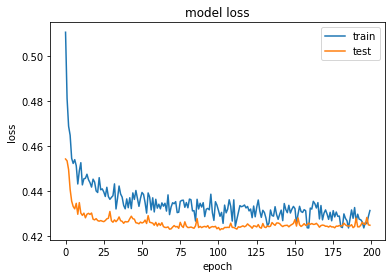

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 59s 14ms/step - loss: 0.5148 - binary_accuracy: 0.7982 - val_loss: 0.4889 - val_binary_accuracy: 0.8123
Epoch 2/200
4241/4241 [==============================] - 2s 455us/step - loss: 0.4790 - binary_accuracy: 0.8149 - val_loss: 0.4759 - val_binary_accuracy: 0.8123
Epoch 3/200
4241/4241 [==============================] - 2s 461us/step - loss: 0.4701 - binary_accuracy: 0.8180 - val_loss: 0.4554 - val_binary_accuracy: 0.8132
Epoch 4/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4682 - binary_accuracy: 0.8168 - val_loss: 0.4641 - val_binary_accuracy: 0.8132
Epoch 5/200
4241/4241 [==============================] - 2s 444us/step - loss: 0.4532 - binary_accuracy: 0.8206 - val_loss: 0.4674 - val_binary_accuracy: 0.8132
Epoch 6/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4514 - binary_accuracy: 0.8199 - val_loss: 0.4528 - val_binary_acc

4241/4241 [==============================] - 2s 439us/step - loss: 0.4327 - binary_accuracy: 0.8255 - val_loss: 0.4305 - val_binary_accuracy: 0.8142
Epoch 102/200
4241/4241 [==============================] - 2s 444us/step - loss: 0.4279 - binary_accuracy: 0.8220 - val_loss: 0.4300 - val_binary_accuracy: 0.8151
Epoch 103/200
4241/4241 [==============================] - 2s 449us/step - loss: 0.4341 - binary_accuracy: 0.8227 - val_loss: 0.4307 - val_binary_accuracy: 0.8132
Epoch 104/200
4241/4241 [==============================] - 2s 459us/step - loss: 0.4295 - binary_accuracy: 0.8236 - val_loss: 0.4296 - val_binary_accuracy: 0.8142
Epoch 105/200
4241/4241 [==============================] - 2s 455us/step - loss: 0.4283 - binary_accuracy: 0.8232 - val_loss: 0.4284 - val_binary_accuracy: 0.8132
Epoch 106/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4335 - binary_accuracy: 0.8201 - val_loss: 0.4323 - val_binary_accuracy: 0.8132
Epoch 107/200
4241/4241 [===========

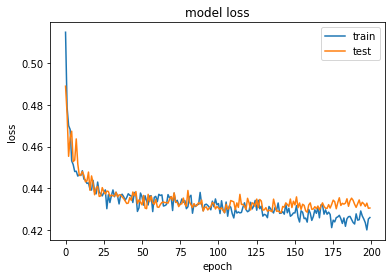

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 63s 15ms/step - loss: 0.5132 - binary_accuracy: 0.7956 - val_loss: 0.5088 - val_binary_accuracy: 0.8075
Epoch 2/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4676 - binary_accuracy: 0.8142 - val_loss: 0.4752 - val_binary_accuracy: 0.8085
Epoch 3/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4716 - binary_accuracy: 0.8182 - val_loss: 0.4679 - val_binary_accuracy: 0.8085
Epoch 4/200
4241/4241 [==============================] - 2s 450us/step - loss: 0.4601 - binary_accuracy: 0.8191 - val_loss: 0.4711 - val_binary_accuracy: 0.8085
Epoch 5/200
4241/4241 [==============================] - 2s 445us/step - loss: 0.4561 - binary_accuracy: 0.8206 - val_loss: 0.4677 - val_binary_accuracy: 0.8085
Epoch 6/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4513 - binary_accuracy: 0.8177 - val_loss: 0.4554 - val_binary_acc

4241/4241 [==============================] - 2s 456us/step - loss: 0.4283 - binary_accuracy: 0.8248 - val_loss: 0.4402 - val_binary_accuracy: 0.8160
Epoch 102/200
4241/4241 [==============================] - 2s 450us/step - loss: 0.4268 - binary_accuracy: 0.8272 - val_loss: 0.4443 - val_binary_accuracy: 0.8113
Epoch 103/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4261 - binary_accuracy: 0.8239 - val_loss: 0.4429 - val_binary_accuracy: 0.8132
Epoch 104/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4236 - binary_accuracy: 0.8243 - val_loss: 0.4378 - val_binary_accuracy: 0.8179
Epoch 105/200
4241/4241 [==============================] - 2s 455us/step - loss: 0.4325 - binary_accuracy: 0.8257 - val_loss: 0.4406 - val_binary_accuracy: 0.8160
Epoch 106/200
4241/4241 [==============================] - 2s 457us/step - loss: 0.4301 - binary_accuracy: 0.8239 - val_loss: 0.4416 - val_binary_accuracy: 0.8151
Epoch 107/200
4241/4241 [===========

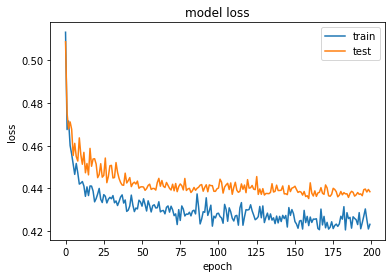

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 61s 14ms/step - loss: 0.5137 - binary_accuracy: 0.7953 - val_loss: 0.4731 - val_binary_accuracy: 0.8236
Epoch 2/200
4241/4241 [==============================] - 2s 452us/step - loss: 0.4834 - binary_accuracy: 0.8097 - val_loss: 0.4631 - val_binary_accuracy: 0.8236
Epoch 3/200
4241/4241 [==============================] - 2s 458us/step - loss: 0.4723 - binary_accuracy: 0.8118 - val_loss: 0.4537 - val_binary_accuracy: 0.8236
Epoch 4/200
4241/4241 [==============================] - 2s 450us/step - loss: 0.4634 - binary_accuracy: 0.8173 - val_loss: 0.4522 - val_binary_accuracy: 0.8236
Epoch 5/200
4241/4241 [==============================] - 2s 453us/step - loss: 0.4540 - binary_accuracy: 0.8158 - val_loss: 0.4475 - val_binary_accuracy: 0.8236
Epoch 6/200
4241/4241 [==============================] - 2s 454us/step - loss: 0.4523 - binary_accuracy: 0.8166 - val_loss: 0.4536 - val_binary_acc

4241/4241 [==============================] - 2s 449us/step - loss: 0.4366 - binary_accuracy: 0.8187 - val_loss: 0.4172 - val_binary_accuracy: 0.8255
Epoch 102/200
4241/4241 [==============================] - 2s 449us/step - loss: 0.4316 - binary_accuracy: 0.8196 - val_loss: 0.4176 - val_binary_accuracy: 0.8236
Epoch 103/200
4241/4241 [==============================] - 2s 446us/step - loss: 0.4319 - binary_accuracy: 0.8199 - val_loss: 0.4163 - val_binary_accuracy: 0.8255
Epoch 104/200
4241/4241 [==============================] - 2s 446us/step - loss: 0.4372 - binary_accuracy: 0.8163 - val_loss: 0.4163 - val_binary_accuracy: 0.8255
Epoch 105/200
4241/4241 [==============================] - 2s 445us/step - loss: 0.4350 - binary_accuracy: 0.8196 - val_loss: 0.4185 - val_binary_accuracy: 0.8255
Epoch 106/200
4241/4241 [==============================] - 2s 450us/step - loss: 0.4342 - binary_accuracy: 0.8177 - val_loss: 0.4179 - val_binary_accuracy: 0.8274
Epoch 107/200
4241/4241 [===========

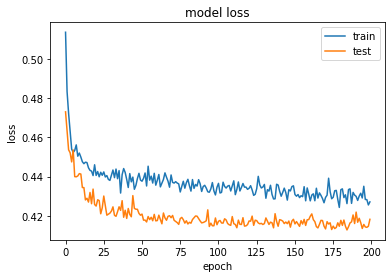

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 59s 14ms/step - loss: 0.5179 - binary_accuracy: 0.7911 - val_loss: 0.4586 - val_binary_accuracy: 0.8292
Epoch 2/200
4241/4241 [==============================] - 2s 465us/step - loss: 0.4816 - binary_accuracy: 0.8109 - val_loss: 0.4412 - val_binary_accuracy: 0.8292
Epoch 3/200
4241/4241 [==============================] - 2s 456us/step - loss: 0.4752 - binary_accuracy: 0.8135 - val_loss: 0.4378 - val_binary_accuracy: 0.8292
Epoch 4/200
4241/4241 [==============================] - 2s 452us/step - loss: 0.4707 - binary_accuracy: 0.8123 - val_loss: 0.4330 - val_binary_accuracy: 0.8292
Epoch 5/200
4241/4241 [==============================] - 2s 465us/step - loss: 0.4654 - binary_accuracy: 0.8158 - val_loss: 0.4341 - val_binary_accuracy: 0.8292
Epoch 6/200
4241/4241 [==============================] - 2s 469us/step - loss: 0.4556 - binary_accuracy: 0.8156 - val_loss: 0.4248 - val_binary_acc

4241/4241 [==============================] - 2s 446us/step - loss: 0.4350 - binary_accuracy: 0.8196 - val_loss: 0.4109 - val_binary_accuracy: 0.8292
Epoch 102/200
4241/4241 [==============================] - 2s 452us/step - loss: 0.4350 - binary_accuracy: 0.8239 - val_loss: 0.4111 - val_binary_accuracy: 0.8311
Epoch 103/200
4241/4241 [==============================] - 2s 447us/step - loss: 0.4309 - binary_accuracy: 0.8222 - val_loss: 0.4109 - val_binary_accuracy: 0.8302
Epoch 104/200
4241/4241 [==============================] - 2s 442us/step - loss: 0.4312 - binary_accuracy: 0.8208 - val_loss: 0.4111 - val_binary_accuracy: 0.8349
Epoch 105/200
4241/4241 [==============================] - 2s 450us/step - loss: 0.4350 - binary_accuracy: 0.8194 - val_loss: 0.4109 - val_binary_accuracy: 0.8292
Epoch 106/200
4241/4241 [==============================] - 2s 448us/step - loss: 0.4347 - binary_accuracy: 0.8232 - val_loss: 0.4123 - val_binary_accuracy: 0.8283
Epoch 107/200
4241/4241 [===========

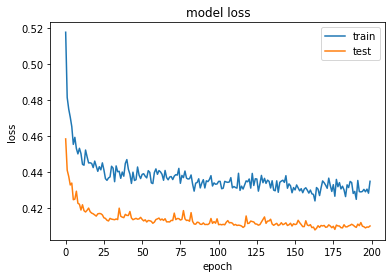

unit: 36	epoch: 200	auroc_mean: 0.728150	auroc_std: 0.011523
Train on 4240 samples, validate on 1061 samples
Epoch 1/200
4240/4240 [==============================] - 63s 15ms/step - loss: 0.5147 - binary_accuracy: 0.8002 - val_loss: 0.4662 - val_binary_accuracy: 0.8228
Epoch 2/200
4240/4240 [==============================] - 2s 408us/step - loss: 0.4825 - binary_accuracy: 0.8120 - val_loss: 0.4501 - val_binary_accuracy: 0.8228
Epoch 3/200
4240/4240 [==============================] - 2s 404us/step - loss: 0.4740 - binary_accuracy: 0.8151 - val_loss: 0.4513 - val_binary_accuracy: 0.8228
Epoch 4/200
4240/4240 [==============================] - 2s 408us/step - loss: 0.4593 - binary_accuracy: 0.8193 - val_loss: 0.4465 - val_binary_accuracy: 0.8228
Epoch 5/200
4240/4240 [==============================] - 2s 400us/step - loss: 0.4614 - binary_accuracy: 0.8158 - val_loss: 0.4373 - val_binary_accuracy: 0.8228
Epoch 6/200
4240/4240 [==============================] - 2s 399us/step - loss: 0.4563 

Epoch 51/200
4240/4240 [==============================] - 2s 389us/step - loss: 0.4314 - binary_accuracy: 0.8217 - val_loss: 0.4258 - val_binary_accuracy: 0.8313
Epoch 52/200
4240/4240 [==============================] - 2s 397us/step - loss: 0.4374 - binary_accuracy: 0.8196 - val_loss: 0.4274 - val_binary_accuracy: 0.8294
Epoch 53/200
4240/4240 [==============================] - 2s 397us/step - loss: 0.4357 - binary_accuracy: 0.8191 - val_loss: 0.4268 - val_binary_accuracy: 0.8266
Epoch 54/200
4240/4240 [==============================] - 2s 393us/step - loss: 0.4368 - binary_accuracy: 0.8189 - val_loss: 0.4274 - val_binary_accuracy: 0.8219
Epoch 55/200
4240/4240 [==============================] - 2s 386us/step - loss: 0.4356 - binary_accuracy: 0.8217 - val_loss: 0.4257 - val_binary_accuracy: 0.8313
Epoch 56/200
4240/4240 [==============================] - 2s 394us/step - loss: 0.4349 - binary_accuracy: 0.8189 - val_loss: 0.4268 - val_binary_accuracy: 0.8285
Epoch 57/200
4240/4240 [====

4240/4240 [==============================] - 2s 392us/step - loss: 0.4285 - binary_accuracy: 0.8229 - val_loss: 0.4267 - val_binary_accuracy: 0.8247
Epoch 152/200
4240/4240 [==============================] - 2s 385us/step - loss: 0.4311 - binary_accuracy: 0.8215 - val_loss: 0.4268 - val_binary_accuracy: 0.8247
Epoch 153/200
4240/4240 [==============================] - 2s 387us/step - loss: 0.4275 - binary_accuracy: 0.8193 - val_loss: 0.4267 - val_binary_accuracy: 0.8247
Epoch 154/200
4240/4240 [==============================] - 2s 386us/step - loss: 0.4293 - binary_accuracy: 0.8210 - val_loss: 0.4272 - val_binary_accuracy: 0.8247
Epoch 155/200
4240/4240 [==============================] - 2s 392us/step - loss: 0.4232 - binary_accuracy: 0.8229 - val_loss: 0.4270 - val_binary_accuracy: 0.8275
Epoch 156/200
4240/4240 [==============================] - 2s 384us/step - loss: 0.4325 - binary_accuracy: 0.8200 - val_loss: 0.4277 - val_binary_accuracy: 0.8228
Epoch 157/200
4240/4240 [===========

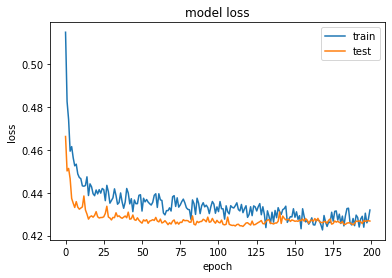

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 58s 14ms/step - loss: 0.5132 - binary_accuracy: 0.8041 - val_loss: 0.4905 - val_binary_accuracy: 0.8123
Epoch 2/200
4241/4241 [==============================] - 2s 470us/step - loss: 0.4775 - binary_accuracy: 0.8137 - val_loss: 0.4933 - val_binary_accuracy: 0.8123
Epoch 3/200
4241/4241 [==============================] - 2s 473us/step - loss: 0.4738 - binary_accuracy: 0.8170 - val_loss: 0.4653 - val_binary_accuracy: 0.8123
Epoch 4/200
4241/4241 [==============================] - 2s 473us/step - loss: 0.4631 - binary_accuracy: 0.8187 - val_loss: 0.4647 - val_binary_accuracy: 0.8123
Epoch 5/200
4241/4241 [==============================] - 2s 467us/step - loss: 0.4573 - binary_accuracy: 0.8196 - val_loss: 0.4493 - val_binary_accuracy: 0.8123
Epoch 6/200
4241/4241 [==============================] - 2s 462us/step - loss: 0.4535 - binary_accuracy: 0.8206 - val_loss: 0.4471 - val_binary_acc

4241/4241 [==============================] - 2s 460us/step - loss: 0.4308 - binary_accuracy: 0.8246 - val_loss: 0.4319 - val_binary_accuracy: 0.8113
Epoch 102/200
4241/4241 [==============================] - 2s 452us/step - loss: 0.4325 - binary_accuracy: 0.8220 - val_loss: 0.4290 - val_binary_accuracy: 0.8123
Epoch 103/200
4241/4241 [==============================] - 2s 452us/step - loss: 0.4335 - binary_accuracy: 0.8220 - val_loss: 0.4310 - val_binary_accuracy: 0.8104
Epoch 104/200
4241/4241 [==============================] - 2s 458us/step - loss: 0.4332 - binary_accuracy: 0.8232 - val_loss: 0.4324 - val_binary_accuracy: 0.8123
Epoch 105/200
4241/4241 [==============================] - 2s 457us/step - loss: 0.4317 - binary_accuracy: 0.8248 - val_loss: 0.4325 - val_binary_accuracy: 0.8123
Epoch 106/200
4241/4241 [==============================] - 2s 451us/step - loss: 0.4328 - binary_accuracy: 0.8248 - val_loss: 0.4342 - val_binary_accuracy: 0.8113
Epoch 107/200
4241/4241 [===========

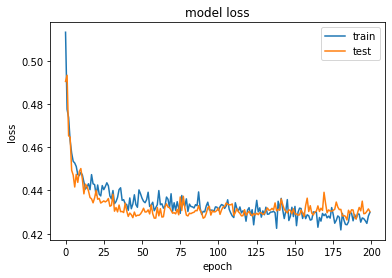

Train on 4241 samples, validate on 1060 samples
Epoch 1/200
4241/4241 [==============================] - 60s 14ms/step - loss: 0.5066 - binary_accuracy: 0.8031 - val_loss: 0.5196 - val_binary_accuracy: 0.8075
Epoch 2/200
4241/4241 [==============================] - 2s 470us/step - loss: 0.4771 - binary_accuracy: 0.8154 - val_loss: 0.4852 - val_binary_accuracy: 0.8075
Epoch 3/200
4241/4241 [==============================] - 2s 469us/step - loss: 0.4671 - binary_accuracy: 0.8191 - val_loss: 0.4761 - val_binary_accuracy: 0.8075
Epoch 4/200
4241/4241 [==============================] - 2s 463us/step - loss: 0.4576 - binary_accuracy: 0.8210 - val_loss: 0.4702 - val_binary_accuracy: 0.8075
Epoch 5/200
4241/4241 [==============================] - 2s 461us/step - loss: 0.4553 - binary_accuracy: 0.8194 - val_loss: 0.4666 - val_binary_accuracy: 0.8075
Epoch 6/200
4241/4241 [==============================] - 2s 467us/step - loss: 0.4556 - binary_accuracy: 0.8199 - val_loss: 0.4564 - val_binary_acc

In [ ]:
# 5-Fold Cross Validation, unit & epoch
result, history = [], []
hparams = [(34, [200]), (36, [200]), (38, [200]), (40, [200])]
for unit, epoch_list in hparams:
    for epoch in epoch_list:
            auroc_list, history = kfold_validation(X_train_transformed, y_train, 'patient-id', unit, epoch)
            result.append((unit, epoch, auroc_list))
            history.append(history)
            print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

In [87]:
for unit, epoch, auroc_list in result:
    print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % 
                  (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 34	epoch: 200	auroc_mean: 0.723622	auroc_std: 0.008857
unit: 36	epoch: 200	auroc_mean: 0.728150	auroc_std: 0.011523
unit: 38	epoch: 200	auroc_mean: 0.727749	auroc_std: 0.013048
unit: 40	epoch: 200	auroc_mean: 0.721738	auroc_std: 0.013084


Train on 4240 samples, validate on 1061 samples
Epoch 1/180
4240/4240 [==============================] - 108s 26ms/step - loss: 0.4662 - binary_accuracy: 0.8179 - val_loss: 0.4284 - val_binary_accuracy: 0.8228
Epoch 2/180
4240/4240 [==============================] - 4s 1ms/step - loss: 0.4374 - binary_accuracy: 0.8186 - val_loss: 0.4255 - val_binary_accuracy: 0.8247
Epoch 3/180
4240/4240 [==============================] - 4s 1ms/step - loss: 0.4272 - binary_accuracy: 0.8200 - val_loss: 0.4231 - val_binary_accuracy: 0.8275
Epoch 4/180
4240/4240 [==============================] - 4s 996us/step - loss: 0.4238 - binary_accuracy: 0.8217 - val_loss: 0.4221 - val_binary_accuracy: 0.8303
Epoch 5/180
4240/4240 [==============================] - 4s 1ms/step - loss: 0.4187 - binary_accuracy: 0.8236 - val_loss: 0.4217 - val_binary_accuracy: 0.8332
Epoch 6/180
4240/4240 [==============================] - 4s 999us/step - loss: 0.4166 - binary_accuracy: 0.8245 - val_loss: 0.4217 - val_binary_accuracy

Epoch 102/180
4240/4240 [==============================] - 4s 992us/step - loss: 0.3846 - binary_accuracy: 0.8349 - val_loss: 0.4278 - val_binary_accuracy: 0.8238
Epoch 103/180
4240/4240 [==============================] - 4s 997us/step - loss: 0.3873 - binary_accuracy: 0.8422 - val_loss: 0.4277 - val_binary_accuracy: 0.8228
Epoch 104/180
4240/4240 [==============================] - 4s 994us/step - loss: 0.3899 - binary_accuracy: 0.8368 - val_loss: 0.4276 - val_binary_accuracy: 0.8219
Epoch 105/180
4240/4240 [==============================] - 4s 990us/step - loss: 0.3834 - binary_accuracy: 0.8408 - val_loss: 0.4276 - val_binary_accuracy: 0.8228
Epoch 106/180
4240/4240 [==============================] - 4s 988us/step - loss: 0.3813 - binary_accuracy: 0.8408 - val_loss: 0.4278 - val_binary_accuracy: 0.8228
Epoch 107/180
4240/4240 [==============================] - 4s 991us/step - loss: 0.3828 - binary_accuracy: 0.8373 - val_loss: 0.4280 - val_binary_accuracy: 0.8219
Epoch 108/180
4240/424

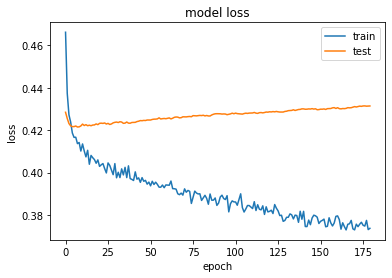

Train on 4241 samples, validate on 1060 samples
Epoch 1/180
4241/4241 [==============================] - 96s 23ms/step - loss: 0.4588 - binary_accuracy: 0.8194 - val_loss: 0.4458 - val_binary_accuracy: 0.8132
Epoch 2/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4265 - binary_accuracy: 0.8239 - val_loss: 0.4402 - val_binary_accuracy: 0.8113
Epoch 3/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4236 - binary_accuracy: 0.8234 - val_loss: 0.4405 - val_binary_accuracy: 0.8113
Epoch 4/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4204 - binary_accuracy: 0.8265 - val_loss: 0.4336 - val_binary_accuracy: 0.8132
Epoch 5/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4196 - binary_accuracy: 0.8283 - val_loss: 0.4314 - val_binary_accuracy: 0.8151
Epoch 6/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4152 - binary_accuracy: 0.8274 - val_loss: 0.4294 - val_binary_accuracy: 0.8

Epoch 52/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3917 - binary_accuracy: 0.8394 - val_loss: 0.4274 - val_binary_accuracy: 0.8123
Epoch 53/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3919 - binary_accuracy: 0.8387 - val_loss: 0.4279 - val_binary_accuracy: 0.8132
Epoch 54/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3918 - binary_accuracy: 0.8373 - val_loss: 0.4274 - val_binary_accuracy: 0.8113
Epoch 55/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3893 - binary_accuracy: 0.8371 - val_loss: 0.4289 - val_binary_accuracy: 0.8142
Epoch 56/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3892 - binary_accuracy: 0.8404 - val_loss: 0.4285 - val_binary_accuracy: 0.8132
Epoch 57/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3894 - binary_accuracy: 0.8411 - val_loss: 0.4285 - val_binary_accuracy: 0.8123
Epoch 58/180
4241/4241 [================

Epoch 154/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3742 - binary_accuracy: 0.8439 - val_loss: 0.4395 - val_binary_accuracy: 0.8085
Epoch 155/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3727 - binary_accuracy: 0.8437 - val_loss: 0.4397 - val_binary_accuracy: 0.8085
Epoch 156/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3684 - binary_accuracy: 0.8441 - val_loss: 0.4407 - val_binary_accuracy: 0.8104
Epoch 157/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3750 - binary_accuracy: 0.8491 - val_loss: 0.4404 - val_binary_accuracy: 0.8085
Epoch 158/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3727 - binary_accuracy: 0.8441 - val_loss: 0.4399 - val_binary_accuracy: 0.8094
Epoch 159/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3743 - binary_accuracy: 0.8456 - val_loss: 0.4406 - val_binary_accuracy: 0.8094
Epoch 160/180
4241/4241 [=========

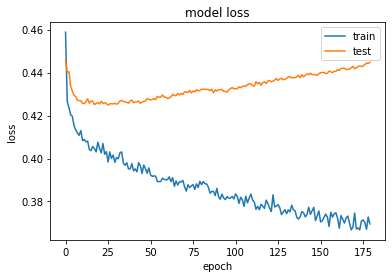

Train on 4241 samples, validate on 1060 samples
Epoch 1/180
4241/4241 [==============================] - 98s 23ms/step - loss: 0.4572 - binary_accuracy: 0.8196 - val_loss: 0.4577 - val_binary_accuracy: 0.8066
Epoch 2/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4282 - binary_accuracy: 0.8227 - val_loss: 0.4521 - val_binary_accuracy: 0.8104
Epoch 3/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4251 - binary_accuracy: 0.8222 - val_loss: 0.4468 - val_binary_accuracy: 0.8179
Epoch 4/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4224 - binary_accuracy: 0.8236 - val_loss: 0.4449 - val_binary_accuracy: 0.8170
Epoch 5/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4154 - binary_accuracy: 0.8290 - val_loss: 0.4425 - val_binary_accuracy: 0.8151
Epoch 6/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4163 - binary_accuracy: 0.8286 - val_loss: 0.4418 - val_binary_accuracy: 0.8

Epoch 52/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3870 - binary_accuracy: 0.8399 - val_loss: 0.4403 - val_binary_accuracy: 0.8094
Epoch 53/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3882 - binary_accuracy: 0.8375 - val_loss: 0.4407 - val_binary_accuracy: 0.8123
Epoch 54/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3921 - binary_accuracy: 0.8368 - val_loss: 0.4428 - val_binary_accuracy: 0.8151
Epoch 55/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3885 - binary_accuracy: 0.8382 - val_loss: 0.4415 - val_binary_accuracy: 0.8113
Epoch 56/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3899 - binary_accuracy: 0.8385 - val_loss: 0.4413 - val_binary_accuracy: 0.8104
Epoch 57/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3883 - binary_accuracy: 0.8364 - val_loss: 0.4420 - val_binary_accuracy: 0.8113
Epoch 58/180
4241/4241 [================

Epoch 154/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3726 - binary_accuracy: 0.8437 - val_loss: 0.4540 - val_binary_accuracy: 0.8113
Epoch 155/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3697 - binary_accuracy: 0.8425 - val_loss: 0.4531 - val_binary_accuracy: 0.8104
Epoch 156/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3686 - binary_accuracy: 0.8481 - val_loss: 0.4535 - val_binary_accuracy: 0.8104
Epoch 157/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3665 - binary_accuracy: 0.8467 - val_loss: 0.4539 - val_binary_accuracy: 0.8094
Epoch 158/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3682 - binary_accuracy: 0.8467 - val_loss: 0.4541 - val_binary_accuracy: 0.8094
Epoch 159/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3674 - binary_accuracy: 0.8491 - val_loss: 0.4542 - val_binary_accuracy: 0.8085
Epoch 160/180
4241/4241 [=========

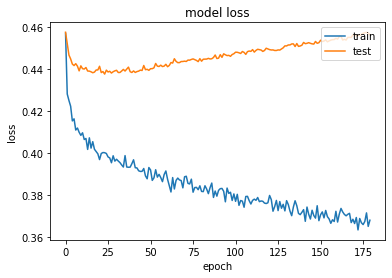

Train on 4241 samples, validate on 1060 samples
Epoch 1/180
4241/4241 [==============================] - 97s 23ms/step - loss: 0.4632 - binary_accuracy: 0.8156 - val_loss: 0.4407 - val_binary_accuracy: 0.8236
Epoch 2/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4356 - binary_accuracy: 0.8199 - val_loss: 0.4306 - val_binary_accuracy: 0.8217
Epoch 3/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4303 - binary_accuracy: 0.8201 - val_loss: 0.4248 - val_binary_accuracy: 0.8226
Epoch 4/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4240 - binary_accuracy: 0.8234 - val_loss: 0.4223 - val_binary_accuracy: 0.8217
Epoch 5/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4272 - binary_accuracy: 0.8227 - val_loss: 0.4197 - val_binary_accuracy: 0.8217
Epoch 6/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4216 - binary_accuracy: 0.8253 - val_loss: 0.4196 - val_binary_accuracy: 0.8

Epoch 52/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3974 - binary_accuracy: 0.8361 - val_loss: 0.4102 - val_binary_accuracy: 0.8330
Epoch 53/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3982 - binary_accuracy: 0.8357 - val_loss: 0.4099 - val_binary_accuracy: 0.8349
Epoch 54/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3949 - binary_accuracy: 0.8335 - val_loss: 0.4094 - val_binary_accuracy: 0.8311
Epoch 55/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3965 - binary_accuracy: 0.8324 - val_loss: 0.4099 - val_binary_accuracy: 0.8311
Epoch 56/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3944 - binary_accuracy: 0.8361 - val_loss: 0.4102 - val_binary_accuracy: 0.8321
Epoch 57/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3975 - binary_accuracy: 0.8335 - val_loss: 0.4102 - val_binary_accuracy: 0.8321
Epoch 58/180
4241/4241 [================

Epoch 154/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3760 - binary_accuracy: 0.8397 - val_loss: 0.4236 - val_binary_accuracy: 0.8311
Epoch 155/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3763 - binary_accuracy: 0.8432 - val_loss: 0.4231 - val_binary_accuracy: 0.8302
Epoch 156/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3760 - binary_accuracy: 0.8434 - val_loss: 0.4240 - val_binary_accuracy: 0.8311
Epoch 157/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3757 - binary_accuracy: 0.8425 - val_loss: 0.4237 - val_binary_accuracy: 0.8292
Epoch 158/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3756 - binary_accuracy: 0.8427 - val_loss: 0.4235 - val_binary_accuracy: 0.8292
Epoch 159/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3780 - binary_accuracy: 0.8415 - val_loss: 0.4232 - val_binary_accuracy: 0.8283
Epoch 160/180
4241/4241 [=========

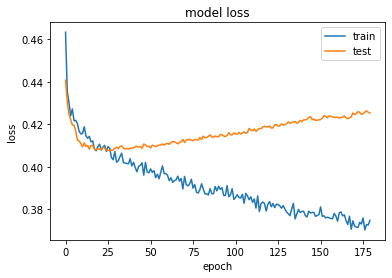

Train on 4241 samples, validate on 1060 samples
Epoch 1/180
4241/4241 [==============================] - 96s 23ms/step - loss: 0.4696 - binary_accuracy: 0.8135 - val_loss: 0.4298 - val_binary_accuracy: 0.8264
Epoch 2/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4385 - binary_accuracy: 0.8189 - val_loss: 0.4227 - val_binary_accuracy: 0.8283
Epoch 3/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4331 - binary_accuracy: 0.8199 - val_loss: 0.4192 - val_binary_accuracy: 0.8245
Epoch 4/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4281 - binary_accuracy: 0.8220 - val_loss: 0.4180 - val_binary_accuracy: 0.8302
Epoch 5/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4243 - binary_accuracy: 0.8239 - val_loss: 0.4165 - val_binary_accuracy: 0.8292
Epoch 6/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4223 - binary_accuracy: 0.8215 - val_loss: 0.4147 - val_binary_accuracy: 0.8

Epoch 52/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.4008 - binary_accuracy: 0.8333 - val_loss: 0.4070 - val_binary_accuracy: 0.8340
Epoch 53/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3985 - binary_accuracy: 0.8331 - val_loss: 0.4072 - val_binary_accuracy: 0.8358
Epoch 54/180
4241/4241 [==============================] - 5s 1ms/step - loss: 0.3992 - binary_accuracy: 0.8300 - val_loss: 0.4071 - val_binary_accuracy: 0.8349
Epoch 55/180
 672/4241 [===>..........................] - ETA: 3s - loss: 0.3903 - binary_accuracy: 0.8304

In [ ]:
# 5-Fold Cross Validation, batch_size
result, history = [], []
hparams = [(22, 180, [0.2, 0.4], [0.2, 0.4])]
for unit, epoch, input_dropout_list, recurrent_dropout_list in hparams:
    for input_dropout in input_dropout_list:
        for recurrent_dropout in recurrent_dropout_list:
            auroc_list, history = kfold_validation(X_train_transformed, y_train, 'patient-id', unit, epoch, 
                                                   input_dropout=input_dropout, recurrent_dropout=recurrent_dropout)
            result.append((unit, epoch, input_dropout, recurrent_dropout, auroc_list))
            history.append(history)
            print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f\tinput_dropout: %f\trecurrent_dropout: %f"  % 
                  (unit, epoch, np.mean(auroc_list), np.std(auroc_list), input_dropout, recurrent_dropout))

In [225]:
for unit, epoch, input_dropout, recurrent_dropout, auroc_list in result:
    print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f\tinput_dropout: %.1f\trecurrent_dropout: %.1f"  % 
                  (unit, epoch, np.mean(auroc_list), np.std(auroc_list), input_dropout, recurrent_dropout))

unit: 22	epoch: 180	auroc_mean: 0.711967	auroc_std: 0.006972	input_dropout: 0.2	recurrent_dropout: 0.2
unit: 22	epoch: 180	auroc_mean: 0.717559	auroc_std: 0.009294	input_dropout: 0.2	recurrent_dropout: 0.4
unit: 22	epoch: 180	auroc_mean: 0.727021	auroc_std: 0.010208	input_dropout: 0.4	recurrent_dropout: 0.2
unit: 22	epoch: 180	auroc_mean: 0.729771	auroc_std: 0.008901	input_dropout: 0.4	recurrent_dropout: 0.4


### Simple RNN
#### sgd, lr=0.03
* unit: 18	epoch: 200	auroc_mean: 0.727032	auroc_std: 0.010871


* unit: 20	epoch: 200	auroc_mean: 0.723746	auroc_std: 0.011319


* unit: 22	epoch: 100	auroc_mean: 0.724037	auroc_std: 0.009859
* unit: 22	epoch: 150	auroc_mean: 0.727301	auroc_std: 0.011433
* unit: 22	epoch: 200	auroc_mean: 0.728536	auroc_std: 0.009915
* unit: 22	epoch: 250	auroc_mean: 0.730769	auroc_std: 0.009391
* unit: 22	epoch: 300	auroc_mean: 0.729731	auroc_std: 0.009882


* unit: 24	epoch: 200	auroc_mean: 0.727169	auroc_std: 0.011480


* unit: 26	epoch: 200	auroc_mean: 0.723848	auroc_std: 0.012333


* unit: 28	epoch: 200	auroc_mean: 0.725291	auroc_std: 0.012330


* unit: 30	epoch: 200	auroc_mean: 0.728152	auroc_std: 0.012254


* unit: 32	epoch: 200	auroc_mean: 0.725119	auroc_std: 0.011935


* unit: 34	epoch: 200	auroc_mean: 0.723622	auroc_std: 0.008857


* unit: 36	epoch: 200	auroc_mean: 0.728150	auroc_std: 0.011523


* unit: 38	epoch: 200	auroc_mean: 0.727749	auroc_std: 0.013048


* unit: 40	epoch: 200	auroc_mean: 0.721738	auroc_std: 0.013084

#### adagrad
* unit: 18	epoch: 200	auroc_mean: 0.722228	auroc_std: 0.012409

## Validation Result - Experiment 1
### Without previous outcome (LSTM)
#### batch_size: 32, input & recurrent dropout: 0.5
* unit: 32	epoch: 100	auroc_mean: 0.696688	auroc_std: 0.014201
* unit: 32	epoch: 150	auroc_mean: 0.696819	auroc_std: 0.013767
* unit: 32	epoch: 200	auroc_mean: 0.696834	auroc_std: 0.013728
* unit: 36	epoch: 100	auroc_mean: 0.695508	auroc_std: 0.014024
* unit: 36	epoch: 150	auroc_mean: 0.695889	auroc_std: 0.013905
* unit: 36	epoch: 200	auroc_mean: 0.695845	auroc_std: 0.013745

### With previous outcome (LSTM)
#### different unit size & epoch
* unit: 10	epoch: 150	auroc_mean: 0.727102	auroc_std: 0.009793
* unit: 10	epoch: 200	auroc_mean: 0.728005	auroc_std: 0.010781


* unit: 14	epoch: 120	auroc_mean: 0.729584	auroc_std: 0.010878
* unit: 14	epoch: 150	auroc_mean: 0.729341	auroc_std: 0.010796


* unit: 18	epoch: 100	auroc_mean: 0.729268	auroc_std: 0.011678
* unit: 18	epoch: 150	auroc_mean: 0.729859	auroc_std: 0.012164


* unit: 22	epoch: 100	auroc_mean: 0.730756	auroc_std: 0.009148
* unit: 22	epoch: 120	auroc_mean: 0.731062	auroc_std: 0.008959
* unit: 22	epoch: 150	auroc_mean: 0.731172	auroc_std: 0.008630
* unit: 22	epoch: 160	auroc_mean: 0.731586	auroc_std: 0.008879
* unit: 22	epoch: 170	auroc_mean: 0.731830	auroc_std: 0.008926
* <span style="color:red">unit: 22	epoch: 180	auroc_mean: 0.732091	auroc_std: 0.008625</span>
* unit: 22	epoch: 190	auroc_mean: 0.731773	auroc_std: 0.008442
* unit: 22	epoch: 200	auroc_mean: 0.731720	auroc_std: 0.008617


* unit: 26	epoch: 70	auroc_mean: 0.729610	auroc_std: 0.010484
* unit: 26	epoch: 100	auroc_mean: 0.729823	auroc_std: 0.011002
* unit: 26	epoch: 150	auroc_mean: 0.729751	auroc_std: 0.010250


* unit: 32	epoch: 40	auroc_mean: 0.726153	auroc_std: 0.011520
* unit: 32	epoch: 50	auroc_mean: 0.726690	auroc_std: 0.011646
* unit: 32	epoch: 60	auroc_mean: 0.727600	auroc_std: 0.012224
* unit: 32	epoch: 70	auroc_mean: 0.728198	auroc_std: 0.012665
* unit: 32	epoch: 80	auroc_mean: 0.728541	auroc_std: 0.011994
* unit: 32	epoch: 180	auroc_mean: 0.729626	auroc_std: 0.011325
* unit: 32	epoch: 200	auroc_mean: 0.729746	auroc_std: 0.010699
* unit: 32	epoch: 210	auroc_mean: 0.729698	auroc_std: 0.011100
* unit: 32	epoch: 220	auroc_mean: 0.729265	auroc_std: 0.011162
* unit: 32	epoch: 230	auroc_mean: 0.729111	auroc_std: 0.011017
* unit: 32	epoch: 240	auroc_mean: 0.728948	auroc_std: 0.011258
* unit: 32	epoch: 250	auroc_mean: 0.728489	auroc_std: 0.010922


* unit: 33	epoch: 120	auroc_mean: 0.727223	auroc_std: 0.009937


* unit: 34	epoch: 120	auroc_mean: 0.729576	auroc_std: 0.010351


* unit: 35	epoch: 120	auroc_mean: 0.731131	auroc_std: 0.010016
* unit: 35	epoch: 150	auroc_mean: 0.730359	auroc_std: 0.009977


* unit: 36	epoch: 90	auroc_mean: 0.729859	auroc_std: 0.010518
* unit: 36	epoch: 100	auroc_mean: 0.730251	auroc_std: 0.009821
* unit: 36	epoch: 110	auroc_mean: 0.730163	auroc_std: 0.009710
* unit: 36	epoch: 120	auroc_mean: 0.730299	auroc_std: 0.010611
* unit: 36	epoch: 130	auroc_mean: 0.729993	auroc_std: 0.010201
* unit: 36	epoch: 140	auroc_mean: 0.730090	auroc_std: 0.010076
* unit: 36	epoch: 150	auroc_mean: 0.730105	auroc_std: 0.010211
* unit: 36	epoch: 180	auroc_mean: 0.729091	auroc_std: 0.009570
* unit: 36	epoch: 190	auroc_mean: 0.728884	auroc_std: 0.009382
* unit: 36	epoch: 200	auroc_mean: 0.728557	auroc_std: 0.009396


* unit: 37	epoch: 120	auroc_mean: 0.729985	auroc_std: 0.009210


#### different batch size
* unit: 22	epoch: 180	auroc_mean: 0.731249	auroc_std: 0.010317  batch_size: 24
* unit: 22	epoch: 180	auroc_mean: 0.731947	auroc_std: 0.008929  batch_size: 28
* unit: 22	epoch: 180	auroc_mean: 0.732091	auroc_std: 0.008625  batch_size: 32
* unit: 22	epoch: 180	auroc_mean: 0.730212	auroc_std: 0.008929  batch_size: 36
* unit: 22	epoch: 180	auroc_mean: 0.731983	auroc_std: 0.008629  batch_size: 40
* unit: 22	epoch: 180	auroc_mean: 0.730337	auroc_std: 0.008635  batch_size: 44

#### different dropout
* unit: 22	epoch: 180	auroc_mean: 0.711967	auroc_std: 0.006972	input_dropout: 0.2	recurrent_dropout: 0.2
* unit: 22	epoch: 180	auroc_mean: 0.717559	auroc_std: 0.009294	input_dropout: 0.2	recurrent_dropout: 0.4
* unit: 22	epoch: 180	auroc_mean: 0.727021	auroc_std: 0.010208	input_dropout: 0.4	recurrent_dropout: 0.2
* unit: 22	epoch: 180	auroc_mean: 0.729771	auroc_std: 0.008901	input_dropout: 0.4	recurrent_dropout: 0.4
* unit: 22	epoch: 180	auroc_mean: 0.731983	auroc_std: 0.008629 input_dropout: 0.5	recurrent_dropout: 0.5

### Stacked LSTM Experiment
#### different 1st layer unit size, fixed 2nd layer unit size=20
* unit: 50	epoch: 100	auroc_mean: 0.726997	auroc_std: 0.010994
* unit: 40	epoch: 100	auroc_mean: 0.729205	auroc_std: 0.010832
* unit: 30	epoch: 100	auroc_mean: 0.729131	auroc_std: 0.009814
* unit: 20	epoch: 100	auroc_mean: 0.727140	auroc_std: 0.010329
* unit: 10	epoch: 100	auroc_mean: 0.723749	auroc_std: 0.011452

#### different 1st layer unit size, fixed 2nd layer unit size=30
* unit: 50	epoch: 100	auroc_mean: 0.729078	auroc_std: 0.010771
* unit: 40	epoch: 100	auroc_mean: 0.731821	auroc_std: 0.010053
* unit: 30	epoch: 100	auroc_mean: 0.728768	auroc_std: 0.011095
* unit: 20	epoch: 100	auroc_mean: 0.729286	auroc_std: 0.010742
* unit: 10	epoch: 100	auroc_mean: 0.722878	auroc_std: 0.011495

#### different 2nd layer unit size, fixed 1st layer unit size=40
* unit: 50	epoch: 100	auroc_mean: 0.730430	auroc_std: 0.011431
* unit: 45	epoch: 100	auroc_mean: 0.731091	auroc_std: 0.011303
* unit: 40	epoch: 100	auroc_mean: 0.729590	auroc_std: 0.010714
* unit: 35	epoch: 100	auroc_mean: 0.730455	auroc_std: 0.010045
* unit: 30	epoch: 100	auroc_mean: 0.731821	auroc_std: 0.010053
* unit: 25	epoch: 100	auroc_mean: 0.730946	auroc_std: 0.010601
* unit: 20	epoch: 100	auroc_mean: 0.729205	auroc_std: 0.010832
* unit: 15	epoch: 100	auroc_mean: 0.728736	auroc_std: 0.007823
* unit: 10	epoch: 100	auroc_mean: 0.730473	auroc_std: 0.011209